In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams["figure.figsize"] = (8, 4)

# Dataset 

In [5]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

#data_path = "../thesis/dataset/EthenT/"
#postfix = "EthenT"
#dim = 72
#N_ELECTRONS = 16
#basis = "6-311++g**"
#data_path = "../thesis/dataset/TSmall/"
#postfix = "TSmall"
#dim = 70
#N_ELECTRONS = 30
#basis = "3-21++g*"
data_path = "../thesis/dataset/ethen0/"
postfix = "ethen0_6-311++g**"
dim = 72
N_ELECTRONS = 30
basis = "6-311++g**"



#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(S))
ind = 0

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])
#molecules = ([], molecules)

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test = S.reshape(-1, dim, dim)
#p_test = S.reshape(-1, dim, dim)

In [6]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    #train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [7]:
def f(x,y):
    return 4*x + 6 * y
f(13,3)

70

In [8]:
from pyscf.scf import hf
h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

# Utilities 

In [9]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


In [10]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

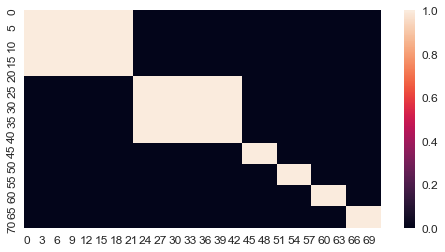

In [11]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [12]:
np.mean(np.abs(p_test.flatten() - embedd_batch(p_test).flatten()))

0.0

In [13]:
from pyscf.scf import hf
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

In [14]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)


# GWH 

In [15]:
from pyscf.scf import hf

p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [16]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-21 22:55:54: Iteration calculation: 0
[ ] 2019-01-21 22:55:54: Iteration calculation: 1
[ ] 2019-01-21 22:55:55: Iteration calculation: 2
[ ] 2019-01-21 22:55:55: Iteration calculation: 3
[ ] 2019-01-21 22:55:56: Iteration calculation: 4
[ ] 2019-01-21 22:55:56: Iteration calculation: 5
[ ] 2019-01-21 22:55:56: Iteration calculation: 6
[ ] 2019-01-21 22:55:57: Iteration calculation: 7
[ ] 2019-01-21 22:55:57: Iteration calculation: 8
[ ] 2019-01-21 22:55:57: Iteration calculation: 9
[ ] 2019-01-21 22:55:58: Iteration calculation: 10
[ ] 2019-01-21 22:55:58: Iteration calculation: 11
[ ] 2019-01-21 22:55:58: Iteration calculation: 12
[ ] 2019-01-21 22:55:59: Iteration calculation: 13
[ ] 2019-01-21 22:55:59: Iteration calculation: 14
[ ] 2019-01-21 22:55:59: Iteration calculation: 15
[ ] 2019-01-21 22:56:00: Iteration calculation: 16
[ ] 2019-01-21 22:56:00: Iteration calculation: 17
[ ] 2019-01-21 22:56:00: Iteration calculation: 18
[ ] 2019-01-21 22:56:01: Iteration calcul

[ ] 2019-01-21 22:56:52: Iteration calculation: 160
[ ] 2019-01-21 22:56:52: Iteration calculation: 161
[ ] 2019-01-21 22:56:53: Iteration calculation: 162
[ ] 2019-01-21 22:56:53: Iteration calculation: 163
[ ] 2019-01-21 22:56:54: Iteration calculation: 164
[ ] 2019-01-21 22:56:54: Iteration calculation: 165
[ ] 2019-01-21 22:56:54: Iteration calculation: 166
[ ] 2019-01-21 22:56:55: Iteration calculation: 167
[ ] 2019-01-21 22:56:55: Iteration calculation: 168
[ ] 2019-01-21 22:56:55: Iteration calculation: 169
[ ] 2019-01-21 22:56:55: Iteration calculation: 170
[ ] 2019-01-21 22:56:56: Iteration calculation: 171
[ ] 2019-01-21 22:56:56: Iteration calculation: 172
[ ] 2019-01-21 22:56:56: Iteration calculation: 173
[ ] 2019-01-21 22:56:57: Iteration calculation: 174
[ ] 2019-01-21 22:56:57: Iteration calculation: 175
[ ] 2019-01-21 22:56:58: Iteration calculation: 176
[ ] 2019-01-21 22:56:58: Iteration calculation: 177
[ ] 2019-01-21 22:56:58: Iteration calculation: 178
[ ] 2019-01-

# Embedded GWH 

In [17]:
p_embedded_gwh = embedd_batch(p_gwh)

In [18]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-21 22:58:10: Iteration calculation: 0
[ ] 2019-01-21 22:58:10: Iteration calculation: 1
[ ] 2019-01-21 22:58:11: Iteration calculation: 2
[ ] 2019-01-21 22:58:11: Iteration calculation: 3
[ ] 2019-01-21 22:58:12: Iteration calculation: 4
[ ] 2019-01-21 22:58:12: Iteration calculation: 5
[ ] 2019-01-21 22:58:12: Iteration calculation: 6
[ ] 2019-01-21 22:58:13: Iteration calculation: 7
[ ] 2019-01-21 22:58:13: Iteration calculation: 8
[ ] 2019-01-21 22:58:13: Iteration calculation: 9
[ ] 2019-01-21 22:58:14: Iteration calculation: 10
[ ] 2019-01-21 22:58:14: Iteration calculation: 11
[ ] 2019-01-21 22:58:14: Iteration calculation: 12
[ ] 2019-01-21 22:58:14: Iteration calculation: 13
[ ] 2019-01-21 22:58:15: Iteration calculation: 14
[ ] 2019-01-21 22:58:15: Iteration calculation: 15
[ ] 2019-01-21 22:58:15: Iteration calculation: 16
[ ] 2019-01-21 22:58:16: Iteration calculation: 17
[ ] 2019-01-21 22:58:16: Iteration calculation: 18
[ ] 2019-01-21 22:58:16: Iteration calcul

[ ] 2019-01-21 22:59:01: Iteration calculation: 160
[ ] 2019-01-21 22:59:01: Iteration calculation: 161
[ ] 2019-01-21 22:59:02: Iteration calculation: 162
[ ] 2019-01-21 22:59:02: Iteration calculation: 163
[ ] 2019-01-21 22:59:02: Iteration calculation: 164
[ ] 2019-01-21 22:59:03: Iteration calculation: 165
[ ] 2019-01-21 22:59:03: Iteration calculation: 166
[ ] 2019-01-21 22:59:03: Iteration calculation: 167
[ ] 2019-01-21 22:59:04: Iteration calculation: 168
[ ] 2019-01-21 22:59:04: Iteration calculation: 169
[ ] 2019-01-21 22:59:04: Iteration calculation: 170
[ ] 2019-01-21 22:59:04: Iteration calculation: 171
[ ] 2019-01-21 22:59:05: Iteration calculation: 172
[ ] 2019-01-21 22:59:05: Iteration calculation: 173
[ ] 2019-01-21 22:59:05: Iteration calculation: 174
[ ] 2019-01-21 22:59:06: Iteration calculation: 175
[ ] 2019-01-21 22:59:06: Iteration calculation: 176
[ ] 2019-01-21 22:59:06: Iteration calculation: 177
[ ] 2019-01-21 22:59:06: Iteration calculation: 178
[ ] 2019-01-

In [19]:
51/1001

0.05094905094905095

# Embedded GWH + 1 Iteration

In [20]:
f_embedded_gwh = fock_from_density_batch(p_embedded_gwh)
p_embedded_gwh_test = density_from_fock_batch(f_embedded_gwh)

In [21]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-21 23:01:17: Iteration calculation: 0
[ ] 2019-01-21 23:01:17: Iteration calculation: 1
[ ] 2019-01-21 23:01:18: Iteration calculation: 2
[ ] 2019-01-21 23:01:18: Iteration calculation: 3
[ ] 2019-01-21 23:01:18: Iteration calculation: 4
[ ] 2019-01-21 23:01:19: Iteration calculation: 5
[ ] 2019-01-21 23:01:19: Iteration calculation: 6
[ ] 2019-01-21 23:01:19: Iteration calculation: 7
[ ] 2019-01-21 23:01:20: Iteration calculation: 8
[ ] 2019-01-21 23:01:20: Iteration calculation: 9
[ ] 2019-01-21 23:01:20: Iteration calculation: 10
[ ] 2019-01-21 23:01:21: Iteration calculation: 11
[ ] 2019-01-21 23:01:21: Iteration calculation: 12
[ ] 2019-01-21 23:01:21: Iteration calculation: 13
[ ] 2019-01-21 23:01:21: Iteration calculation: 14
[ ] 2019-01-21 23:01:22: Iteration calculation: 15
[ ] 2019-01-21 23:01:22: Iteration calculation: 16
[ ] 2019-01-21 23:01:22: Iteration calculation: 17
[ ] 2019-01-21 23:01:23: Iteration calculation: 18
[ ] 2019-01-21 23:01:23: Iteration calcul

[ ] 2019-01-21 23:02:11: Iteration calculation: 160
[ ] 2019-01-21 23:02:11: Iteration calculation: 161
[ ] 2019-01-21 23:02:11: Iteration calculation: 162
[ ] 2019-01-21 23:02:12: Iteration calculation: 163
[ ] 2019-01-21 23:02:12: Iteration calculation: 164
[ ] 2019-01-21 23:02:12: Iteration calculation: 165
[ ] 2019-01-21 23:02:13: Iteration calculation: 166
[ ] 2019-01-21 23:02:13: Iteration calculation: 167
[ ] 2019-01-21 23:02:13: Iteration calculation: 168
[ ] 2019-01-21 23:02:14: Iteration calculation: 169
[ ] 2019-01-21 23:02:14: Iteration calculation: 170
[ ] 2019-01-21 23:02:14: Iteration calculation: 171
[ ] 2019-01-21 23:02:14: Iteration calculation: 172
[ ] 2019-01-21 23:02:15: Iteration calculation: 173
[ ] 2019-01-21 23:02:15: Iteration calculation: 174
[ ] 2019-01-21 23:02:15: Iteration calculation: 175
[ ] 2019-01-21 23:02:16: Iteration calculation: 176
[ ] 2019-01-21 23:02:16: Iteration calculation: 177
[ ] 2019-01-21 23:02:16: Iteration calculation: 178
[ ] 2019-01-

# SAD 

In [22]:
from pyscf.scf import hf

p_sad = np.array([ 
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

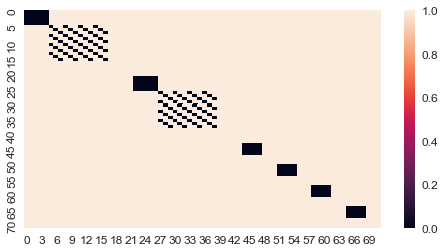

In [23]:
sns.heatmap((abs(p_sad[0]) < 1e-12).astype("int"))

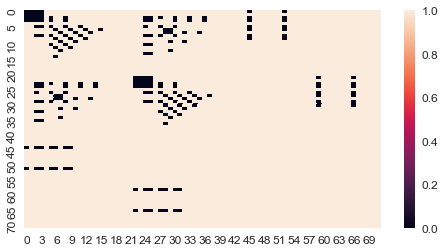

In [24]:
sns.heatmap((abs(p_gwh[0]) < 0.05).astype("int"))

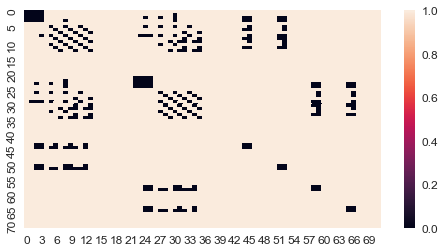

In [25]:
sns.heatmap((abs(p_test[30]) < 0.05).astype("int"))

In [26]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-21 23:04:02: Iteration calculation: 0
[ ] 2019-01-21 23:04:02: Iteration calculation: 1
[ ] 2019-01-21 23:04:03: Iteration calculation: 2
[ ] 2019-01-21 23:04:03: Iteration calculation: 3
[ ] 2019-01-21 23:04:04: Iteration calculation: 4
[ ] 2019-01-21 23:04:04: Iteration calculation: 5
[ ] 2019-01-21 23:04:04: Iteration calculation: 6
[ ] 2019-01-21 23:04:05: Iteration calculation: 7
[ ] 2019-01-21 23:04:05: Iteration calculation: 8
[ ] 2019-01-21 23:04:06: Iteration calculation: 9
[ ] 2019-01-21 23:04:06: Iteration calculation: 10
[ ] 2019-01-21 23:04:06: Iteration calculation: 11
[ ] 2019-01-21 23:04:07: Iteration calculation: 12
[ ] 2019-01-21 23:04:07: Iteration calculation: 13
[ ] 2019-01-21 23:04:07: Iteration calculation: 14
[ ] 2019-01-21 23:04:08: Iteration calculation: 15
[ ] 2019-01-21 23:04:08: Iteration calculation: 16
[ ] 2019-01-21 23:04:08: Iteration calculation: 17
[ ] 2019-01-21 23:04:09: Iteration calculation: 18
[ ] 2019-01-21 23:04:09: Iteration calcul

[ ] 2019-01-21 23:05:00: Iteration calculation: 160
[ ] 2019-01-21 23:05:00: Iteration calculation: 161
[ ] 2019-01-21 23:05:00: Iteration calculation: 162
[ ] 2019-01-21 23:05:01: Iteration calculation: 163
[ ] 2019-01-21 23:05:01: Iteration calculation: 164
[ ] 2019-01-21 23:05:01: Iteration calculation: 165
[ ] 2019-01-21 23:05:02: Iteration calculation: 166
[ ] 2019-01-21 23:05:02: Iteration calculation: 167
[ ] 2019-01-21 23:05:02: Iteration calculation: 168
[ ] 2019-01-21 23:05:03: Iteration calculation: 169
[ ] 2019-01-21 23:05:03: Iteration calculation: 170
[ ] 2019-01-21 23:05:03: Iteration calculation: 171
[ ] 2019-01-21 23:05:04: Iteration calculation: 172
[ ] 2019-01-21 23:05:04: Iteration calculation: 173
[ ] 2019-01-21 23:05:04: Iteration calculation: 174
[ ] 2019-01-21 23:05:05: Iteration calculation: 175
[ ] 2019-01-21 23:05:05: Iteration calculation: 176
[ ] 2019-01-21 23:05:06: Iteration calculation: 177
[ ] 2019-01-21 23:05:06: Iteration calculation: 178
[ ] 2019-01-

In [27]:
47/1001

0.04695304695304695

# Embedded zeros 

In [28]:
p_embedded_zeros = embedd_batch(np.zeros(p_test.shape))

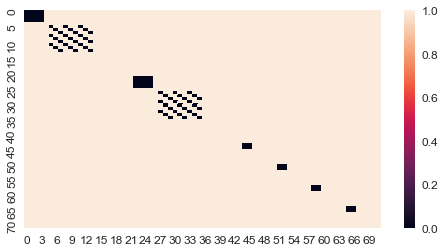

In [29]:
sns.heatmap((abs(p_embedded_zeros[0]) < 0.05).astype("int"))

In [30]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_zeros,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-21 23:06:27: Iteration calculation: 0
[ ] 2019-01-21 23:06:27: Iteration calculation: 1
[ ] 2019-01-21 23:06:27: Iteration calculation: 2
[ ] 2019-01-21 23:06:28: Iteration calculation: 3
[ ] 2019-01-21 23:06:28: Iteration calculation: 4
[ ] 2019-01-21 23:06:29: Iteration calculation: 5
[ ] 2019-01-21 23:06:29: Iteration calculation: 6
[ ] 2019-01-21 23:06:29: Iteration calculation: 7
[ ] 2019-01-21 23:06:30: Iteration calculation: 8
[ ] 2019-01-21 23:06:30: Iteration calculation: 9
[ ] 2019-01-21 23:06:30: Iteration calculation: 10
[ ] 2019-01-21 23:06:31: Iteration calculation: 11
[ ] 2019-01-21 23:06:31: Iteration calculation: 12
[ ] 2019-01-21 23:06:32: Iteration calculation: 13
[ ] 2019-01-21 23:06:32: Iteration calculation: 14
[ ] 2019-01-21 23:06:32: Iteration calculation: 15
[ ] 2019-01-21 23:06:33: Iteration calculation: 16
[ ] 2019-01-21 23:06:33: Iteration calculation: 17
[ ] 2019-01-21 23:06:33: Iteration calculation: 18
[ ] 2019-01-21 23:06:34: Iteration calcul

[ ] 2019-01-21 23:07:30: Iteration calculation: 160
[ ] 2019-01-21 23:07:30: Iteration calculation: 161
[ ] 2019-01-21 23:07:30: Iteration calculation: 162
[ ] 2019-01-21 23:07:31: Iteration calculation: 163
[ ] 2019-01-21 23:07:31: Iteration calculation: 164
[ ] 2019-01-21 23:07:31: Iteration calculation: 165
[ ] 2019-01-21 23:07:32: Iteration calculation: 166
[ ] 2019-01-21 23:07:32: Iteration calculation: 167
[ ] 2019-01-21 23:07:32: Iteration calculation: 168
[ ] 2019-01-21 23:07:33: Iteration calculation: 169
[ ] 2019-01-21 23:07:33: Iteration calculation: 170
[ ] 2019-01-21 23:07:33: Iteration calculation: 171
[ ] 2019-01-21 23:07:34: Iteration calculation: 172
[ ] 2019-01-21 23:07:34: Iteration calculation: 173
[ ] 2019-01-21 23:07:34: Iteration calculation: 174
[ ] 2019-01-21 23:07:35: Iteration calculation: 175
[ ] 2019-01-21 23:07:35: Iteration calculation: 176
[ ] 2019-01-21 23:07:35: Iteration calculation: 177
[ ] 2019-01-21 23:07:36: Iteration calculation: 178
[ ] 2019-01-

# Embedded zeros + 1 Iteration? 

In [31]:
f_embedded_zeros = fock_from_density_batch(p_embedded_zeros)
p_embedded_zeros_test = density_from_fock_batch(f_embedded_zeros,)

In [32]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    p_embedded_zeros_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-21 23:09:54: Iteration calculation: 0
[ ] 2019-01-21 23:09:54: Iteration calculation: 1
[ ] 2019-01-21 23:09:55: Iteration calculation: 2
[ ] 2019-01-21 23:09:55: Iteration calculation: 3
[ ] 2019-01-21 23:09:56: Iteration calculation: 4
[ ] 2019-01-21 23:09:56: Iteration calculation: 5
[ ] 2019-01-21 23:09:56: Iteration calculation: 6
[ ] 2019-01-21 23:09:57: Iteration calculation: 7
[ ] 2019-01-21 23:09:57: Iteration calculation: 8
[ ] 2019-01-21 23:09:57: Iteration calculation: 9
[ ] 2019-01-21 23:09:58: Iteration calculation: 10
[ ] 2019-01-21 23:09:58: Iteration calculation: 11
[ ] 2019-01-21 23:09:59: Iteration calculation: 12
[ ] 2019-01-21 23:09:59: Iteration calculation: 13
[ ] 2019-01-21 23:09:59: Iteration calculation: 14
[ ] 2019-01-21 23:10:00: Iteration calculation: 15
[ ] 2019-01-21 23:10:00: Iteration calculation: 16
[ ] 2019-01-21 23:10:00: Iteration calculation: 17
[ ] 2019-01-21 23:10:01: Iteration calculation: 18
[ ] 2019-01-21 23:10:01: Iteration calcul

[ ] 2019-01-21 23:10:55: Iteration calculation: 160
[ ] 2019-01-21 23:10:55: Iteration calculation: 161
[ ] 2019-01-21 23:10:56: Iteration calculation: 162
[ ] 2019-01-21 23:10:56: Iteration calculation: 163
[ ] 2019-01-21 23:10:56: Iteration calculation: 164
[ ] 2019-01-21 23:10:57: Iteration calculation: 165
[ ] 2019-01-21 23:10:57: Iteration calculation: 166
[ ] 2019-01-21 23:10:57: Iteration calculation: 167
[ ] 2019-01-21 23:10:58: Iteration calculation: 168
[ ] 2019-01-21 23:10:58: Iteration calculation: 169
[ ] 2019-01-21 23:10:58: Iteration calculation: 170
[ ] 2019-01-21 23:10:59: Iteration calculation: 171
[ ] 2019-01-21 23:10:59: Iteration calculation: 172
[ ] 2019-01-21 23:10:59: Iteration calculation: 173
[ ] 2019-01-21 23:11:00: Iteration calculation: 174
[ ] 2019-01-21 23:11:00: Iteration calculation: 175
[ ] 2019-01-21 23:11:00: Iteration calculation: 176
[ ] 2019-01-21 23:11:01: Iteration calculation: 177
[ ] 2019-01-21 23:11:01: Iteration calculation: 178
[ ] 2019-01-

#  

In [33]:
77/1001

0.07692307692307693

# Embedded GWH w/ Self-Overlap 

In [34]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_self_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i == atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_self_overlap = np.logical_or(mask_self_overlap, m)
    
#mask

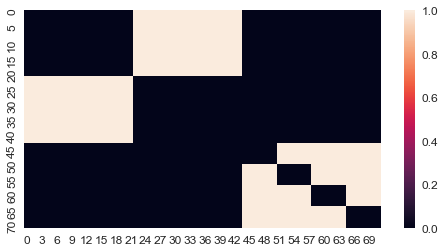

In [35]:
import seaborn as sns

sns.heatmap(mask_self_overlap.astype("int"))

In [36]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_self_ovlp(x, y):
    p = x.copy()
    p[mask_self_overlap] = (y.copy())[mask_self_overlap]
    return p

def embedd_batch_self_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_self_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [37]:
p_embedded_gwh_self_ovlp = embedd_batch_self_ovlp(p_embedded_gwh)

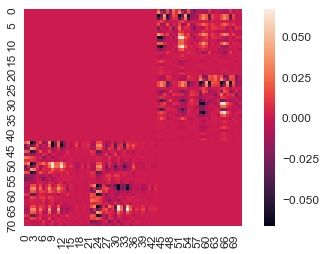

In [38]:
sns.heatmap(p_embedded_gwh_self_ovlp[0] - p_test[0], square=True)

In [39]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_self_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-21 23:13:25: Iteration calculation: 0
[ ] 2019-01-21 23:13:25: Iteration calculation: 1
[ ] 2019-01-21 23:13:25: Iteration calculation: 2
[ ] 2019-01-21 23:13:26: Iteration calculation: 3
[ ] 2019-01-21 23:13:26: Iteration calculation: 4
[ ] 2019-01-21 23:13:27: Iteration calculation: 5
[ ] 2019-01-21 23:13:27: Iteration calculation: 6
[ ] 2019-01-21 23:13:27: Iteration calculation: 7
[ ] 2019-01-21 23:13:28: Iteration calculation: 8
[ ] 2019-01-21 23:13:28: Iteration calculation: 9
[ ] 2019-01-21 23:13:29: Iteration calculation: 10
[ ] 2019-01-21 23:13:29: Iteration calculation: 11
[ ] 2019-01-21 23:13:29: Iteration calculation: 12
[ ] 2019-01-21 23:13:30: Iteration calculation: 13
[ ] 2019-01-21 23:13:30: Iteration calculation: 14
[ ] 2019-01-21 23:13:31: Iteration calculation: 15
[ ] 2019-01-21 23:13:31: Iteration calculation: 16
[ ] 2019-01-21 23:13:31: Iteration calculation: 17
[ ] 2019-01-21 23:13:32: Iteration calculation: 18
[ ] 2019-01-21 23:13:32: Iteration calcul

[ ] 2019-01-21 23:14:26: Iteration calculation: 160
[ ] 2019-01-21 23:14:26: Iteration calculation: 161
[ ] 2019-01-21 23:14:27: Iteration calculation: 162
[ ] 2019-01-21 23:14:27: Iteration calculation: 163
[ ] 2019-01-21 23:14:27: Iteration calculation: 164
[ ] 2019-01-21 23:14:28: Iteration calculation: 165
[ ] 2019-01-21 23:14:28: Iteration calculation: 166
[ ] 2019-01-21 23:14:28: Iteration calculation: 167
[ ] 2019-01-21 23:14:29: Iteration calculation: 168
[ ] 2019-01-21 23:14:29: Iteration calculation: 169
[ ] 2019-01-21 23:14:30: Iteration calculation: 170
[ ] 2019-01-21 23:14:30: Iteration calculation: 171
[ ] 2019-01-21 23:14:30: Iteration calculation: 172
[ ] 2019-01-21 23:14:31: Iteration calculation: 173
[ ] 2019-01-21 23:14:31: Iteration calculation: 174
[ ] 2019-01-21 23:14:32: Iteration calculation: 175
[ ] 2019-01-21 23:14:32: Iteration calculation: 176
[ ] 2019-01-21 23:14:32: Iteration calculation: 177
[ ] 2019-01-21 23:14:33: Iteration calculation: 178
[ ] 2019-01-

In [40]:
6/(len(p_test))

0.029850746268656716

# Embedded GWH w/ OFF overlap

In [41]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_off_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i != atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_off_overlap = np.logical_or(mask_off_overlap, m)
    
#mask

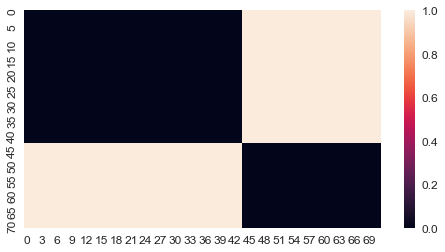

In [42]:
import seaborn as sns

sns.heatmap(mask_off_overlap.astype("int"))

In [43]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_off_ovlp(x, y):
    p = x.copy()
    p[mask_off_overlap] = (y.copy())[mask_off_overlap]
    return p

def embedd_batch_off_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_off_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [44]:
p_embedded_gwh_off_ovlp = embedd_batch_off_ovlp(p_embedded_gwh)

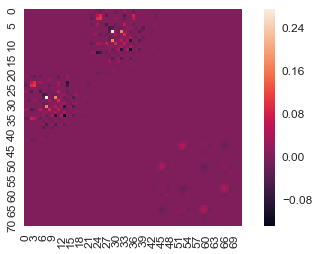

In [45]:
sns.heatmap(p_embedded_gwh_off_ovlp[0] - p_test[0], square=True)

In [46]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_off_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-21 23:17:02: Iteration calculation: 0
[ ] 2019-01-21 23:17:03: Iteration calculation: 1
[ ] 2019-01-21 23:17:03: Iteration calculation: 2
[ ] 2019-01-21 23:17:04: Iteration calculation: 3
[ ] 2019-01-21 23:17:04: Iteration calculation: 4
[ ] 2019-01-21 23:17:04: Iteration calculation: 5
[ ] 2019-01-21 23:17:05: Iteration calculation: 6
[ ] 2019-01-21 23:17:05: Iteration calculation: 7
[ ] 2019-01-21 23:17:05: Iteration calculation: 8
[ ] 2019-01-21 23:17:06: Iteration calculation: 9
[ ] 2019-01-21 23:17:06: Iteration calculation: 10
[ ] 2019-01-21 23:17:06: Iteration calculation: 11
[ ] 2019-01-21 23:17:07: Iteration calculation: 12
[ ] 2019-01-21 23:17:07: Iteration calculation: 13
[ ] 2019-01-21 23:17:07: Iteration calculation: 14
[ ] 2019-01-21 23:17:08: Iteration calculation: 15
[ ] 2019-01-21 23:17:08: Iteration calculation: 16
[ ] 2019-01-21 23:17:08: Iteration calculation: 17
[ ] 2019-01-21 23:17:09: Iteration calculation: 18
[ ] 2019-01-21 23:17:09: Iteration calcul

[ ] 2019-01-21 23:17:59: Iteration calculation: 160
[ ] 2019-01-21 23:17:59: Iteration calculation: 161
[ ] 2019-01-21 23:18:00: Iteration calculation: 162
[ ] 2019-01-21 23:18:00: Iteration calculation: 163
[ ] 2019-01-21 23:18:00: Iteration calculation: 164
[ ] 2019-01-21 23:18:01: Iteration calculation: 165
[ ] 2019-01-21 23:18:01: Iteration calculation: 166
[ ] 2019-01-21 23:18:01: Iteration calculation: 167
[ ] 2019-01-21 23:18:02: Iteration calculation: 168
[ ] 2019-01-21 23:18:02: Iteration calculation: 169
[ ] 2019-01-21 23:18:02: Iteration calculation: 170
[ ] 2019-01-21 23:18:03: Iteration calculation: 171
[ ] 2019-01-21 23:18:03: Iteration calculation: 172
[ ] 2019-01-21 23:18:03: Iteration calculation: 173
[ ] 2019-01-21 23:18:04: Iteration calculation: 174
[ ] 2019-01-21 23:18:04: Iteration calculation: 175
[ ] 2019-01-21 23:18:04: Iteration calculation: 176
[ ] 2019-01-21 23:18:05: Iteration calculation: 177
[ ] 2019-01-21 23:18:05: Iteration calculation: 178
[ ] 2019-01-

In [47]:
7/len(p_test)

0.03482587064676617